# Pancreas endocrinogenesis E1415 - TrajectoryNet

### Imports and Settings

In [43]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import scanpy as sc
import cellrank as cr
import scvelo as scv


In [68]:
from tueplots import bundles
from tueplots import axes
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update(**bundles.neurips2022(usetex=False, nrows=2), **axes.lines(base_width=0.5), **{"figure.dpi": 250})

scv.set_figure_params('scvelo', fontsize=20, color_map='viridis', dpi=400)  # for beautified visualization

cr.logging.print_versions()

cellrank==1.5.1+g16069e2 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.1 numba==0.53.1 scipy==1.9.0 pandas==1.3.5 pygpcca==1.0.3 scikit-learn==1.1.2 statsmodels==0.13.2 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


## Get Data

In [111]:
adata = sc.read("/home/icb/giovanni.palla/neural-ot-data/results/pancreas/adata_velocity.h5ad")

In [112]:
del adata.uns["velocity_graph"]
del adata.uns["velocity_graph_neg"]
del adata.uns["velocity_params"]
del adata.obs["velocity_self_transition"]
del adata.obsm["velocity_umap"]

In [113]:
from neural_ot.utils import get_neural_dual_from_ckpt, mmd_rbf, sinkhorn_loss

In [115]:
adata.layers["velocity"] = -1 * adata.layers["velocity"].copy()

In [116]:
old_adata = sc.read("../neural_ot/data/pancreas/1415_growth_rate.h5ad")

In [117]:
# Prepare for Cellrank
adata.obs["clusters"] = old_adata.obs["celltype"]
adata.layers["pca"] = adata.X.copy()
adata.obs["clusters"] = old_adata.obs["celltype"].copy()
adata.uns["neighbors"] = old_adata.uns["neighbors"].copy()
adata.obsp["connectivities"] = old_adata.obsp["connectivities"].copy()
adata.obsp["distances"] = old_adata.obsp["distances"].copy()

In [118]:
print(sinkhorn_loss(adata[adata.obs["day"] == "14.5"].X + adata[adata.obs["day"] == "14.5"].layers["velocity"], adata[adata.obs["day"] == "15.5"].X))

132.77145


## Alternatively load precomputed adata

In [ ]:
adata = sc.read("adata_results/pancreas1415_trajectorynet.h5ad")

## Cellrank

### Transition Probabilities

In [119]:
vk = cr.kernels.VelocityKernel(adata, xkey="pca")
vk.compute_transition_matrix()

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

VelocityKernel

### Macrostate and Terminalstate Calculation

In [120]:
g = cr.estimators.GPCCA(vk)

Mat Object: 1 MPI processes
  type: seqdense
9.9999999999999223e-01 -1.9320778538084481e-03 9.8171976861820552e-05 -1.2162468908307235e-03 2.9500439047991690e-03 -2.6877896906857919e-03 6.0412056392694109e-03 8.9636740136723124e-04 -3.3441772101986561e-03 3.9973349338100661e-04 3.2021728729260943e-03 3.0203118759515027e-04 2.6668475541427377e-03 1.0398667367999383e-03 -1.3721714713138034e-02 -1.9866424775585509e-04 -9.2462468180133945e-03 -2.8712916381208749e-03 4.1064375087283512e-03 -1.1079055573824193e-03 -3.8973274946287428e-03 
0.0000000000000000e+00 9.9727044037404078e-01 3.6534720076584321e-03 2.0700665679641234e-03 1.0989462470154979e-03 1.1406647172675184e-03 -1.9496190615105441e-03 5.4887651496905981e-03 -3.0738388244719622e-03 -3.6150379685833340e-03 -1.8767581602437288e-04 -1.3365842273605282e-03 7.6668144073121331e-04 8.9161303603446011e-04 9.1852689077148823e-03 -7.3028434654355935e-04 6.4299777043218013e-03 -4.5793825506584042e-03 -3.2666580042578925e-04 4.01862124515483

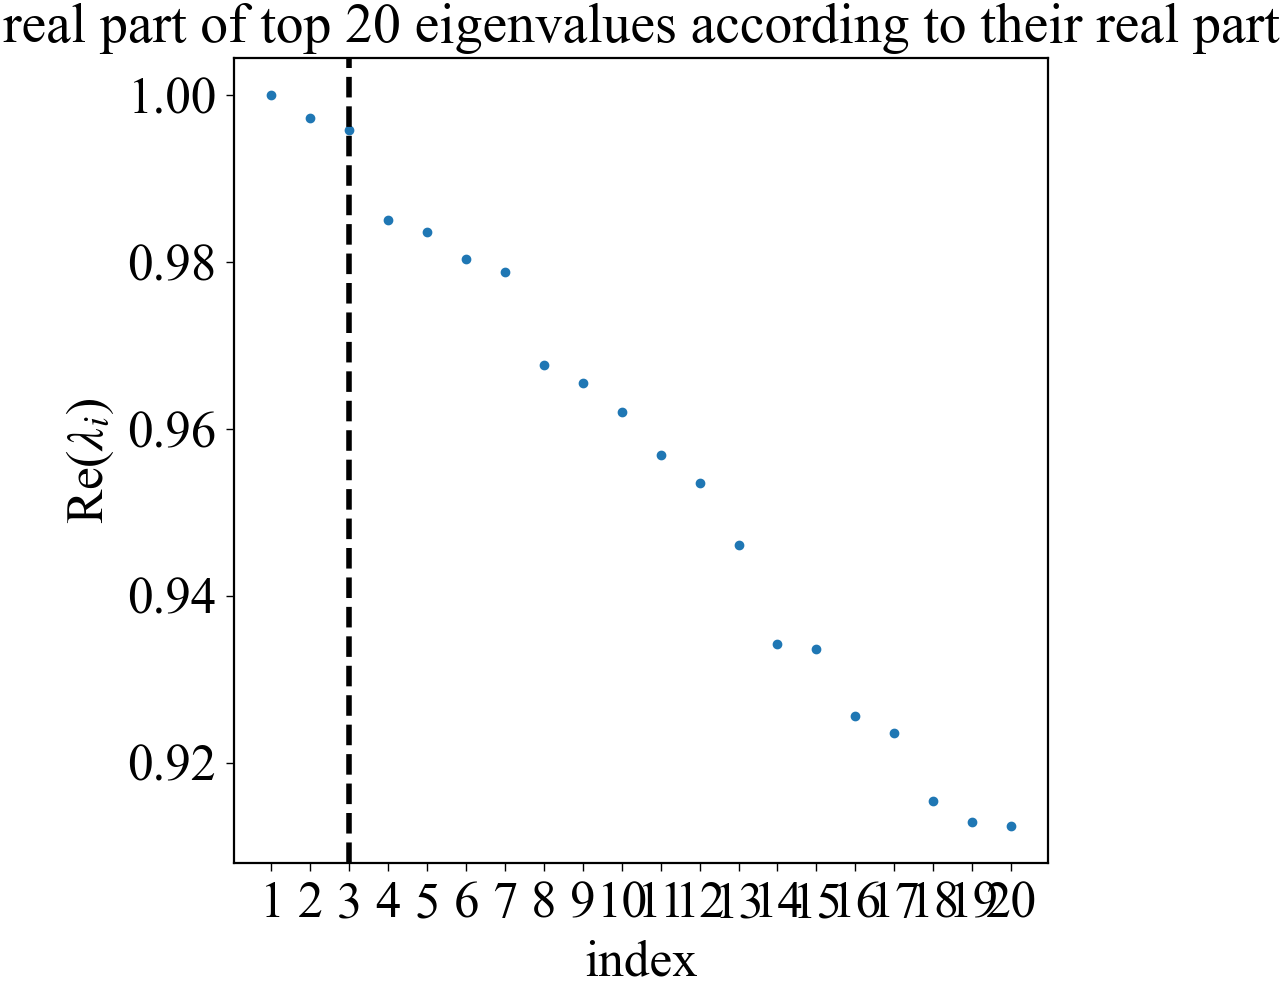

In [121]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [122]:
g.compute_macrostates(n_states=10, cluster_key="celltype")

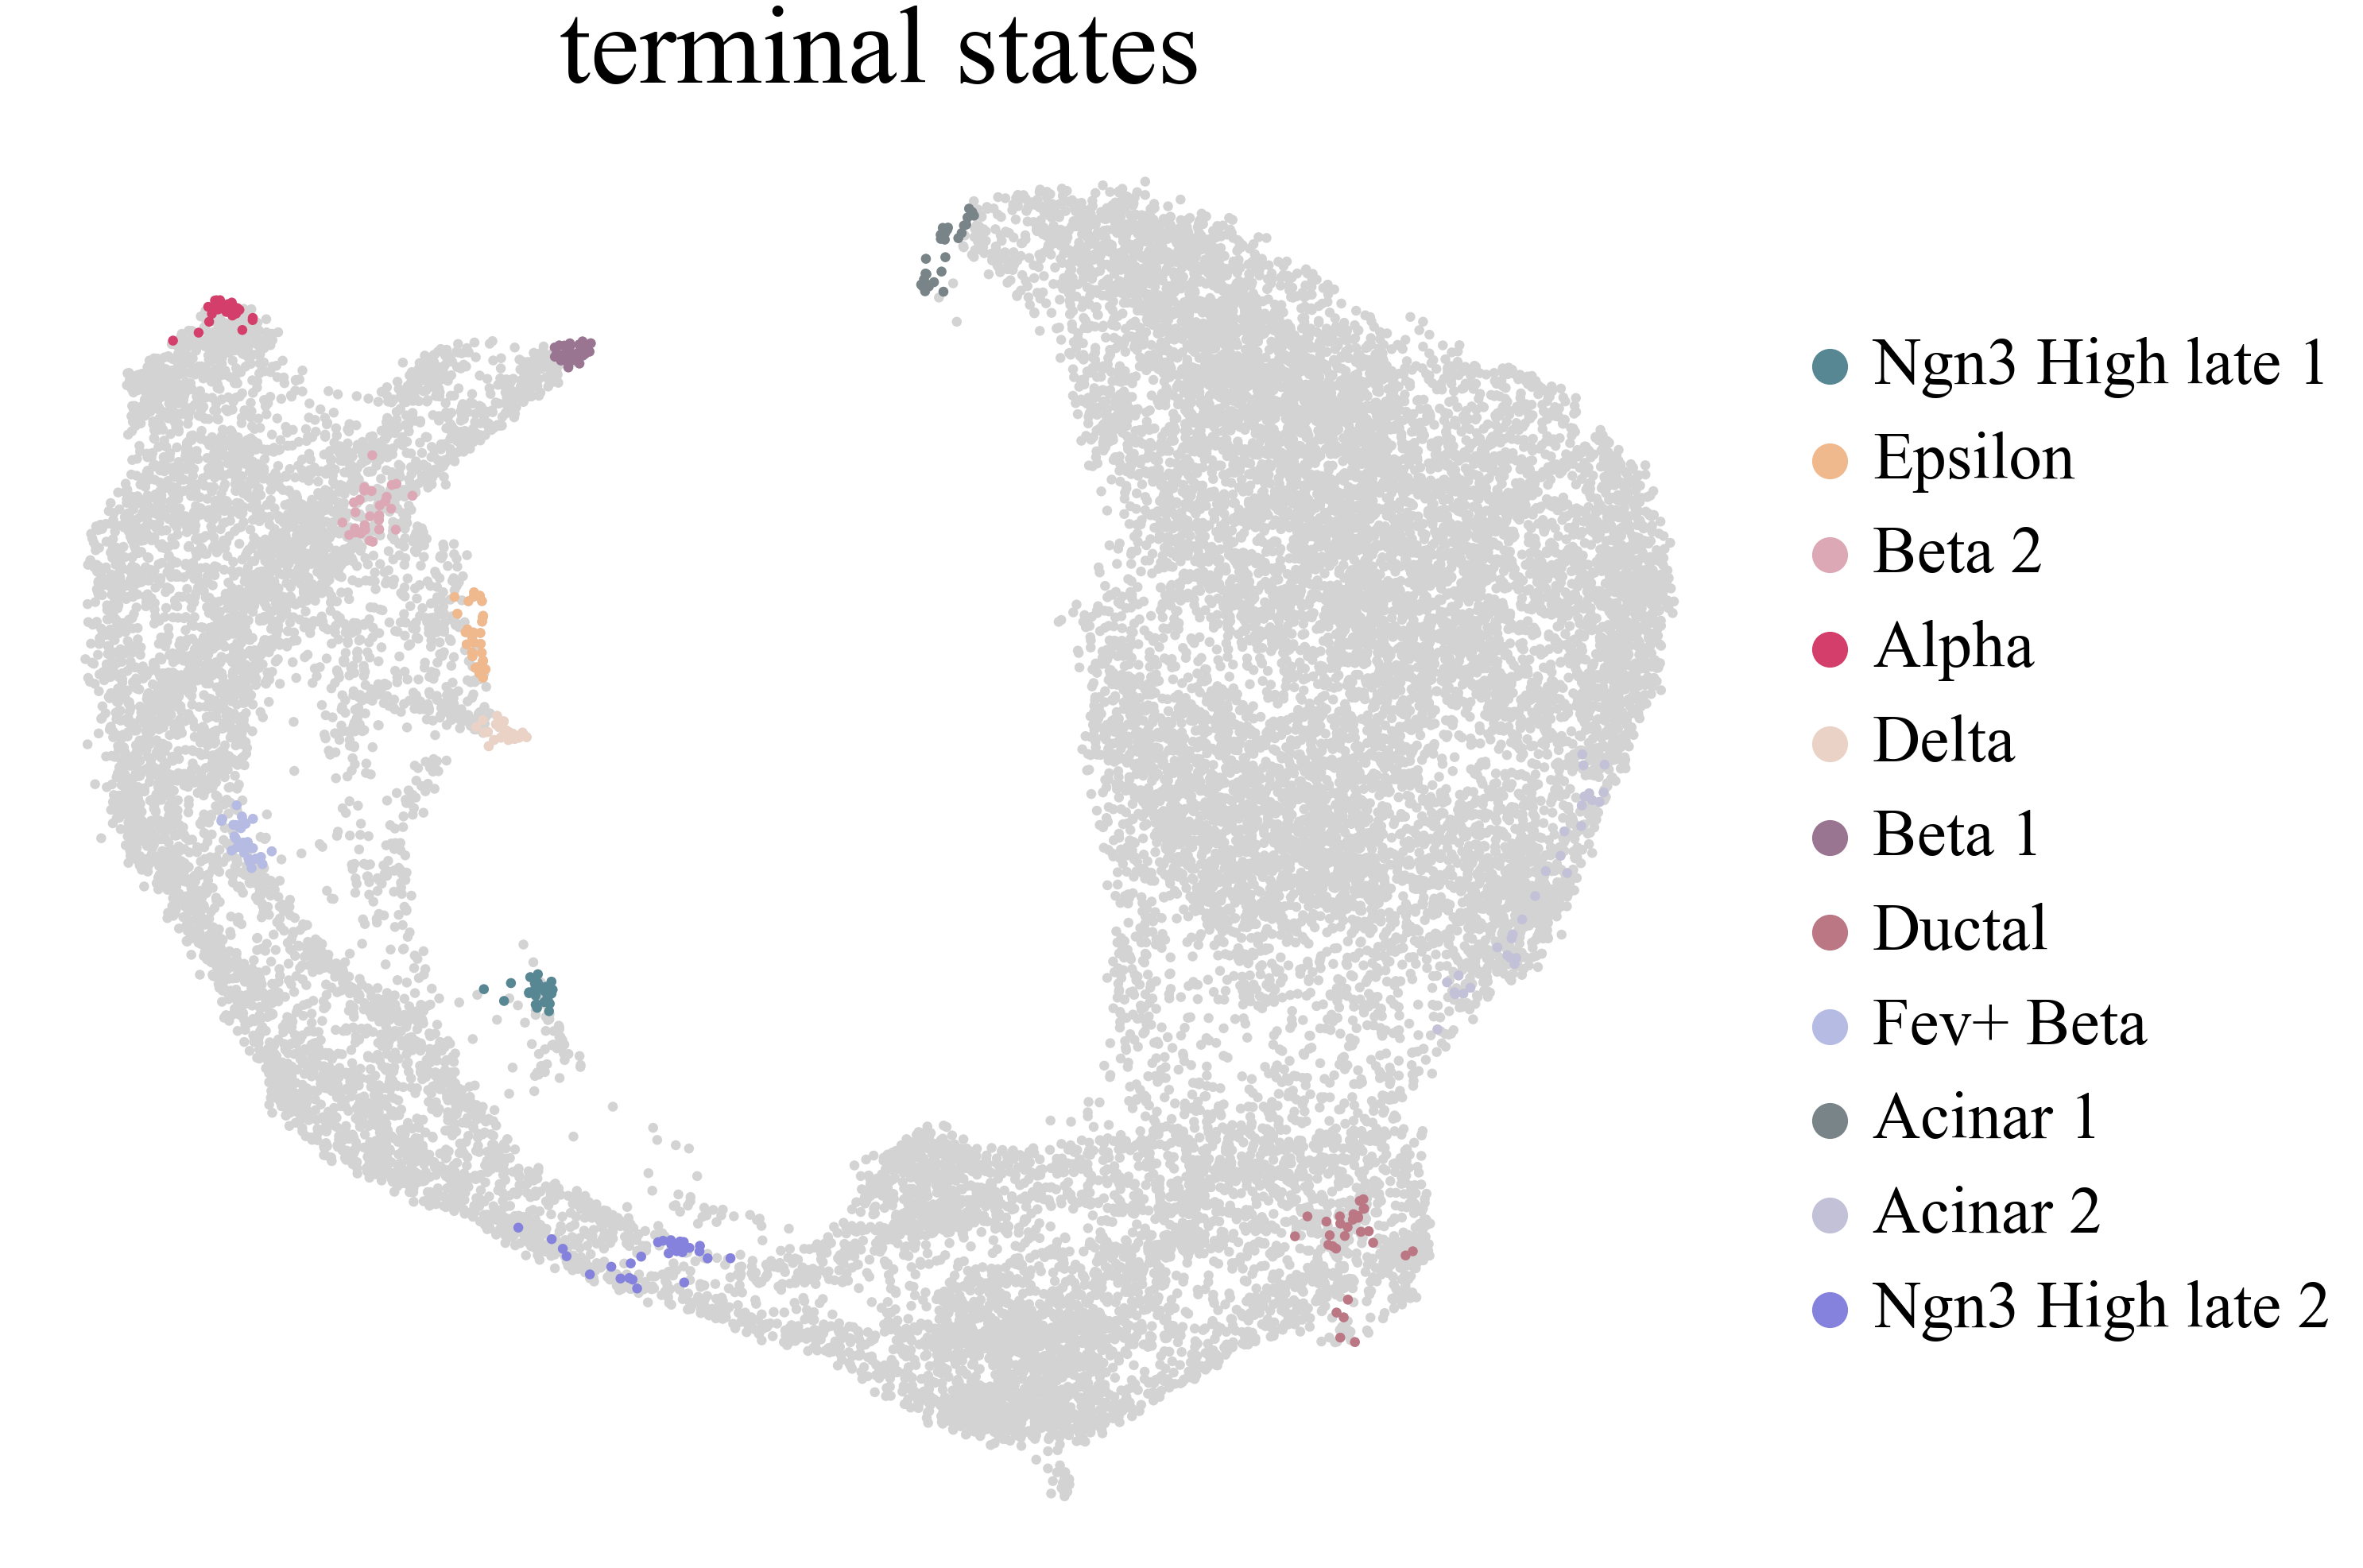

In [123]:
g.compute_terminal_states(method="top_n", n_states=10)
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_terminal_states(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate Probabilities

  0%|          | 0/8 [00:00<?, ?/s]

[0]PETSC ERROR: 

  0%|          | 0/1 [00:00<?, ?/s]

[0]PETSC ERROR: 

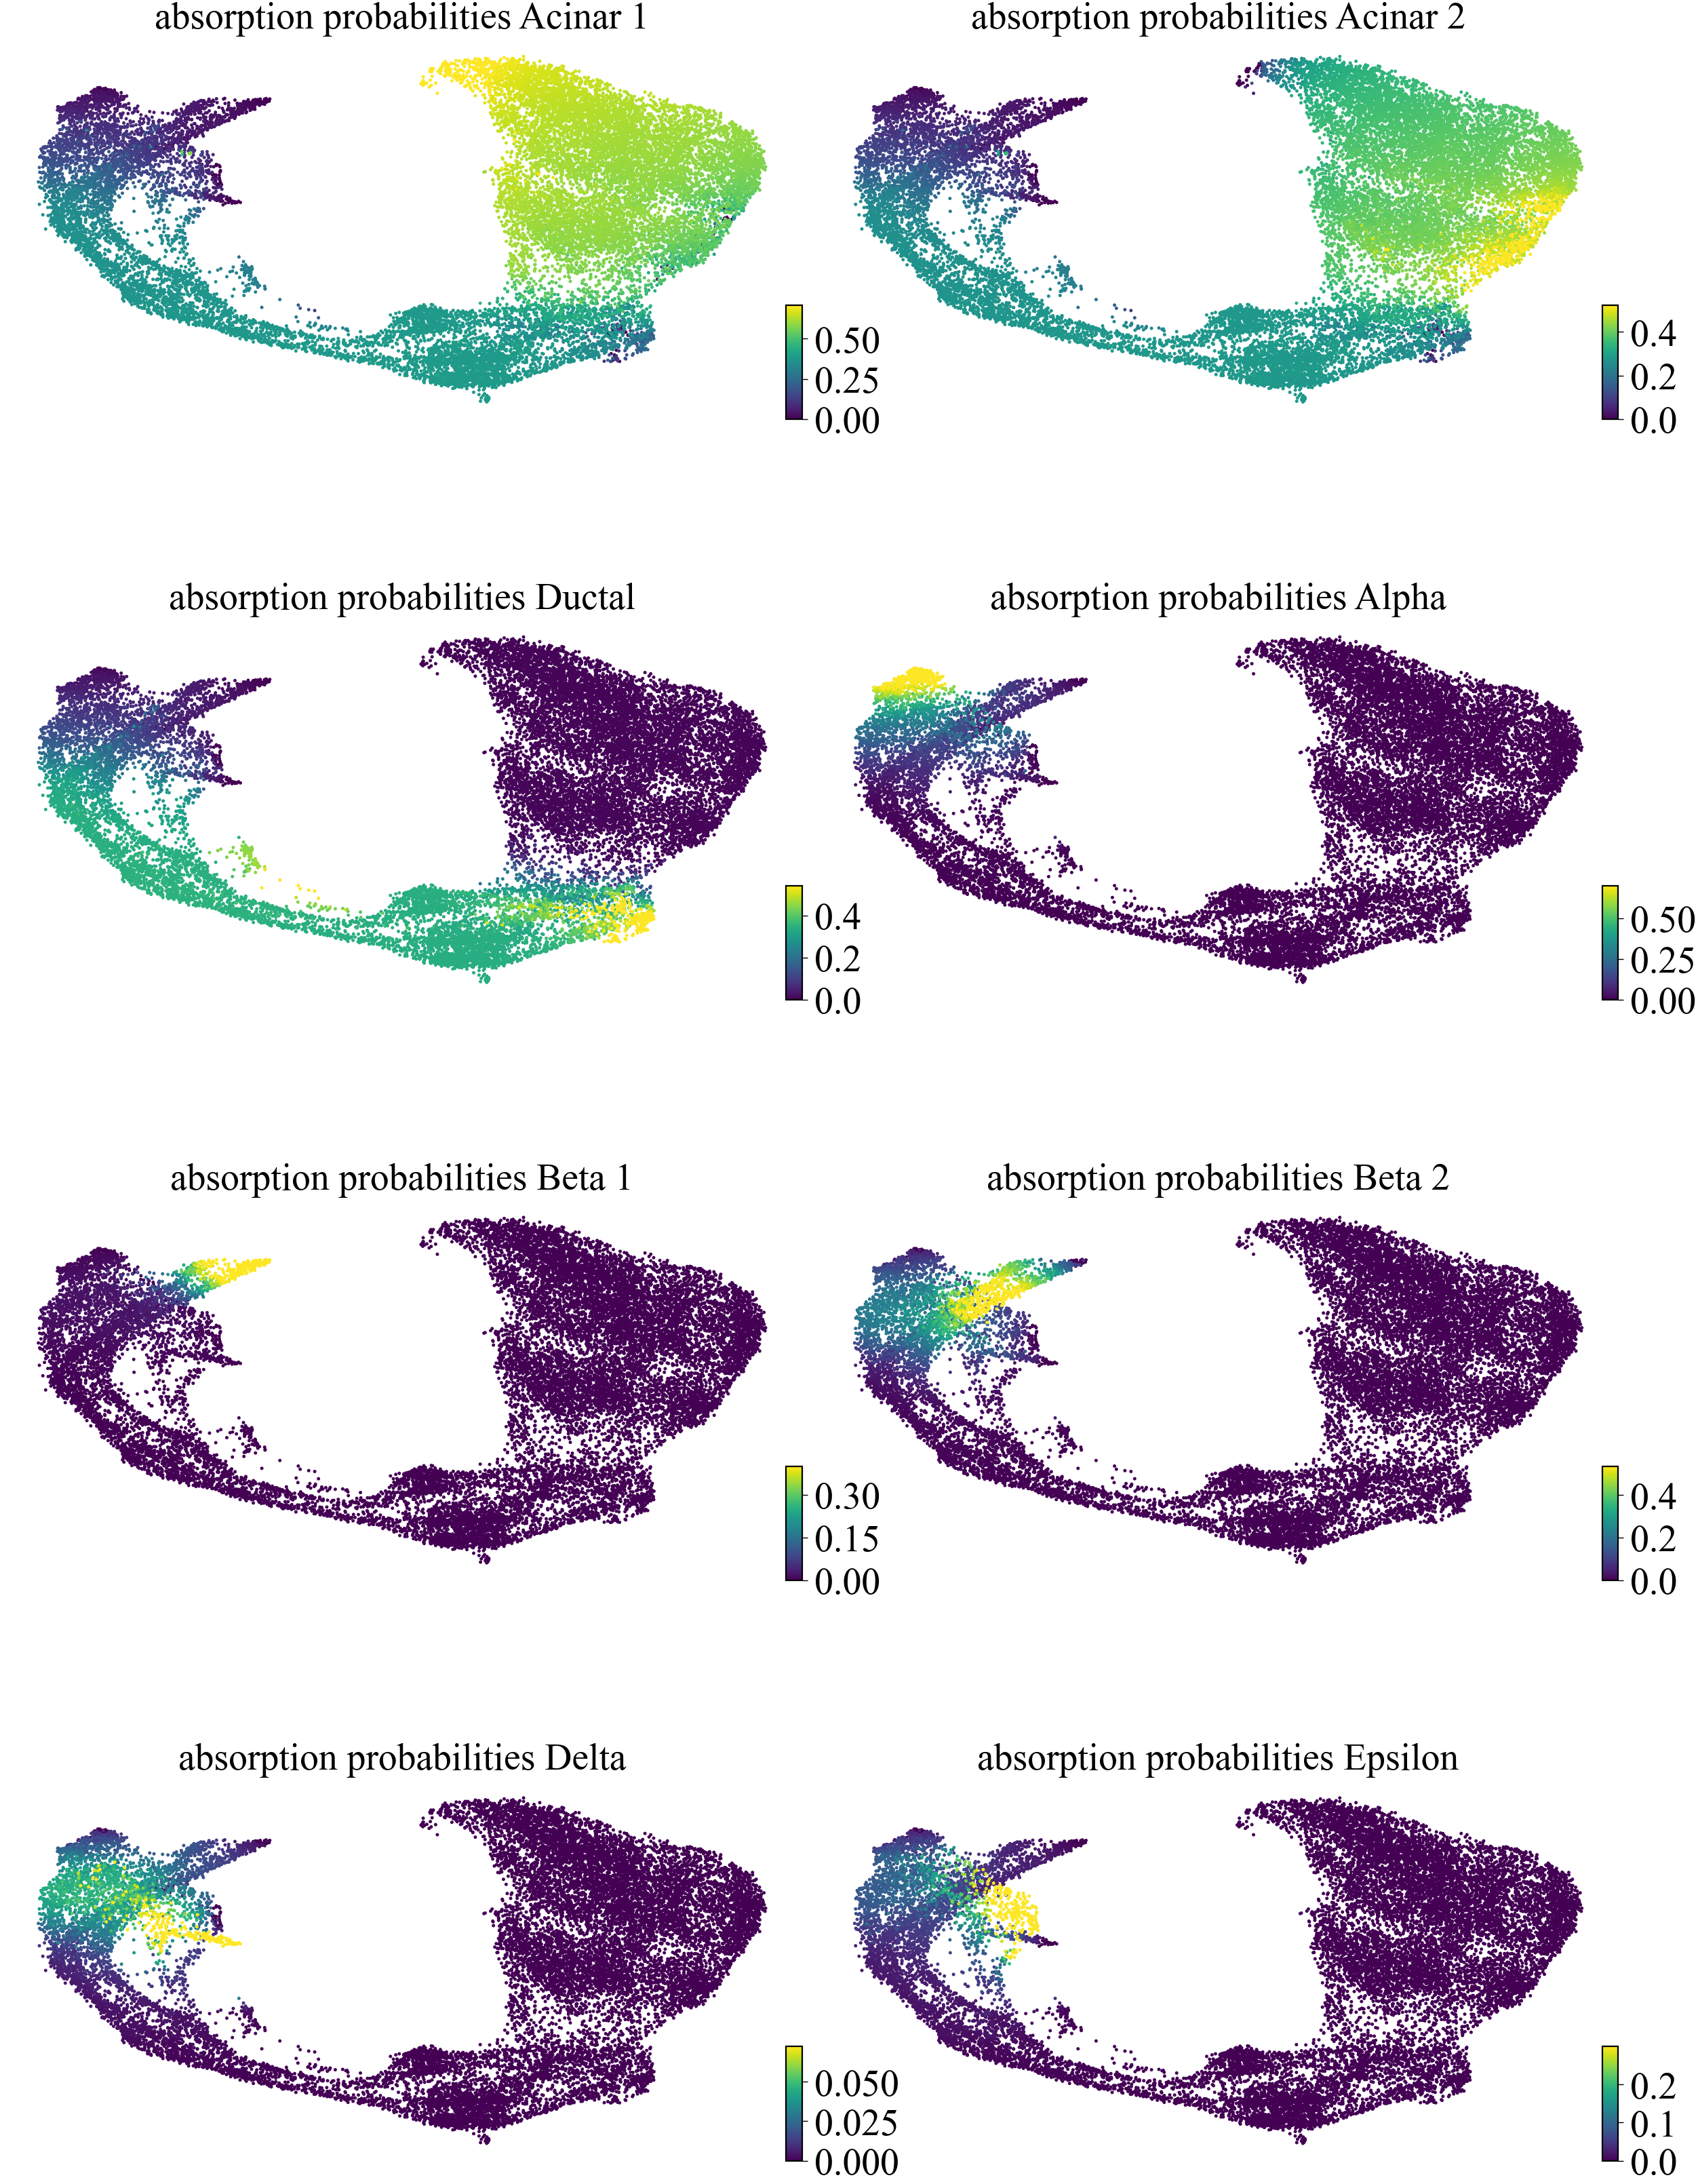

In [124]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta_1", "Beta_2", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

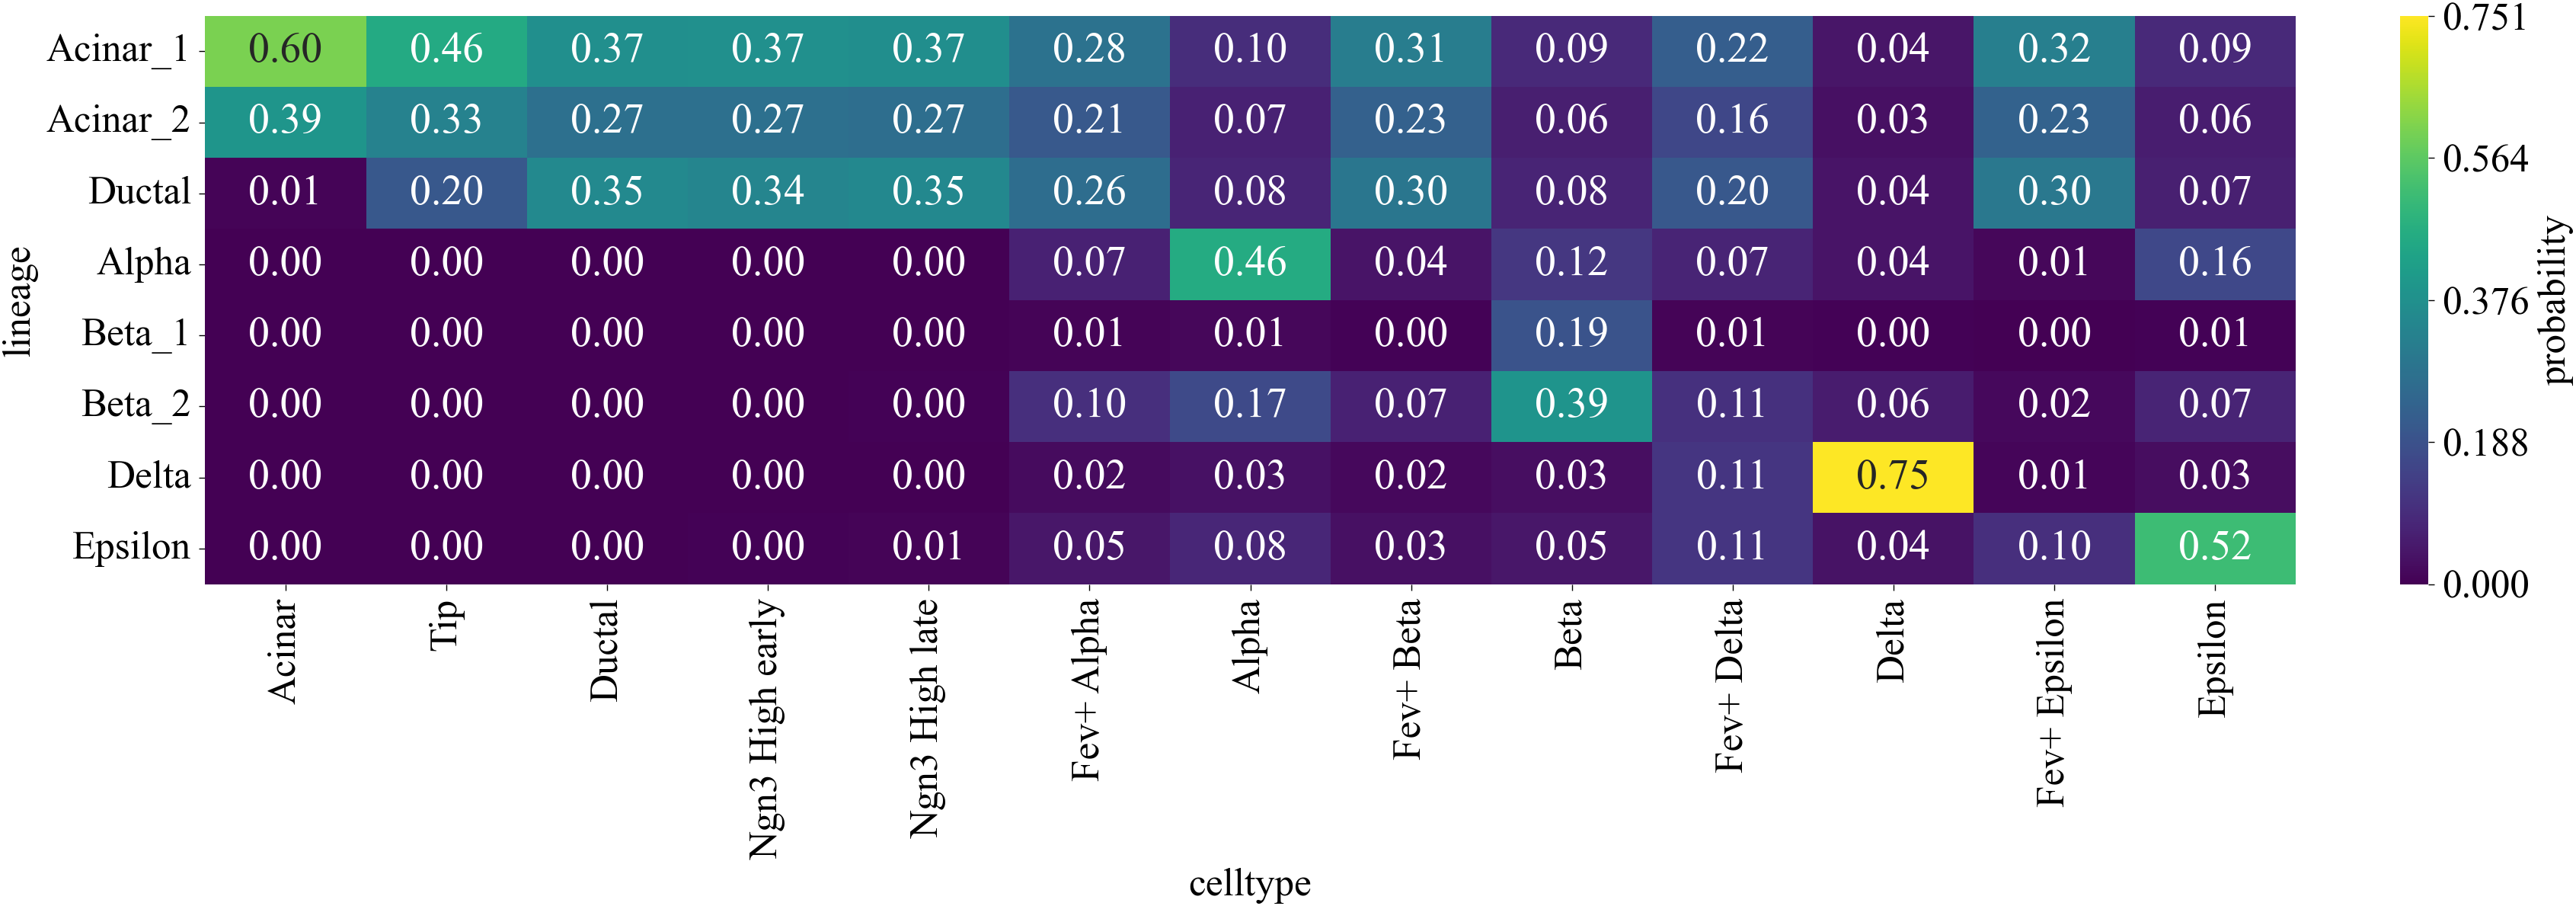

In [125]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=
    [
         "Acinar_1", "Acinar_2", "Ductal", "Alpha", "Beta_1", "Beta_2", "Delta", "Epsilon"
    ],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
    #save="transprobs_pancreas1415_trajectorynet.png"
)

### Velocity Embedding Stream Plot

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


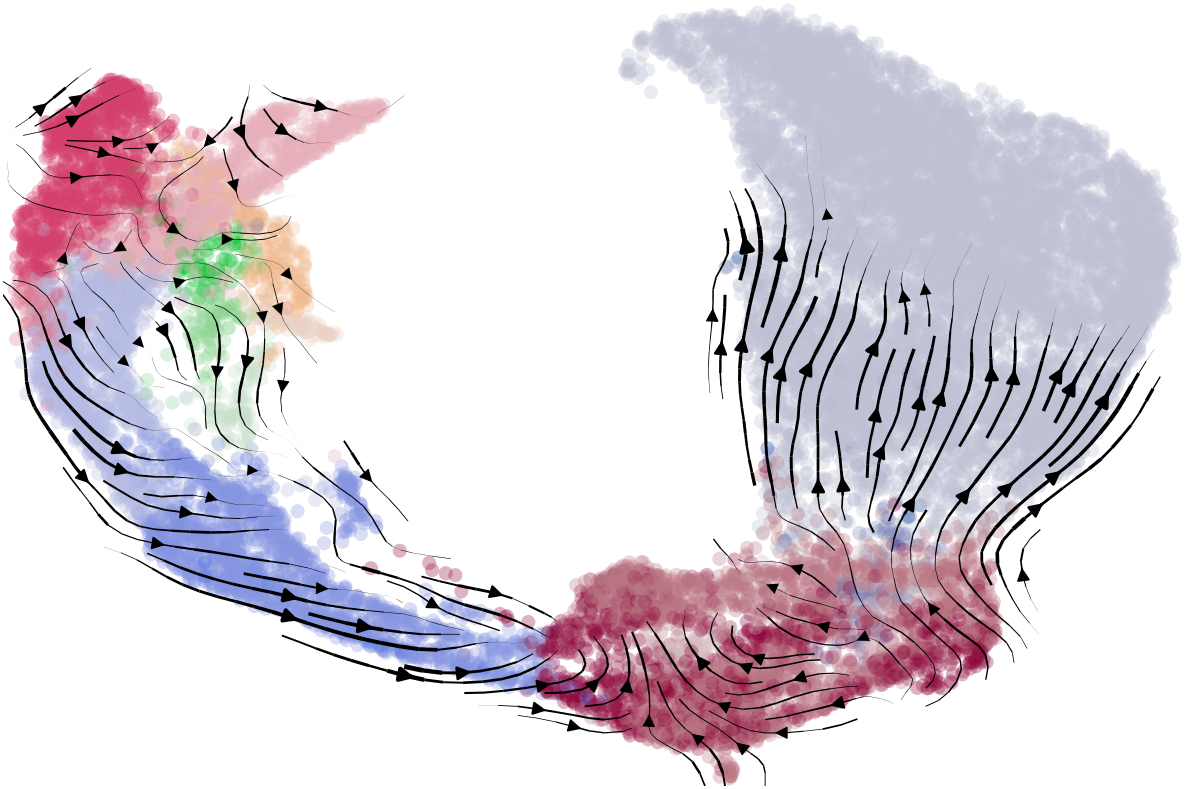

In [128]:
adata.uns["velocity_graph"] = vk.transition_matrix
scv.pl.velocity_embedding_stream(adata,
                                 basis="umap",
                                 title="",
                                 legend_loc="none",
                                 smooth=0.5, 
                                 #save="velstream_pancreas1415_trajectorynet.png"
                                )

In [129]:
adata.layers["Ms"] = adata.layers["pca"].copy()
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [84]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False

scv.settings.set_figure_params('scvelo', dpi_save=800, dpi=400, transparent=True, fontsize=20, color_map='viridis')

saving figure to file ./figures/scvelo_velconf_pancreas1415_trajectorynet.png


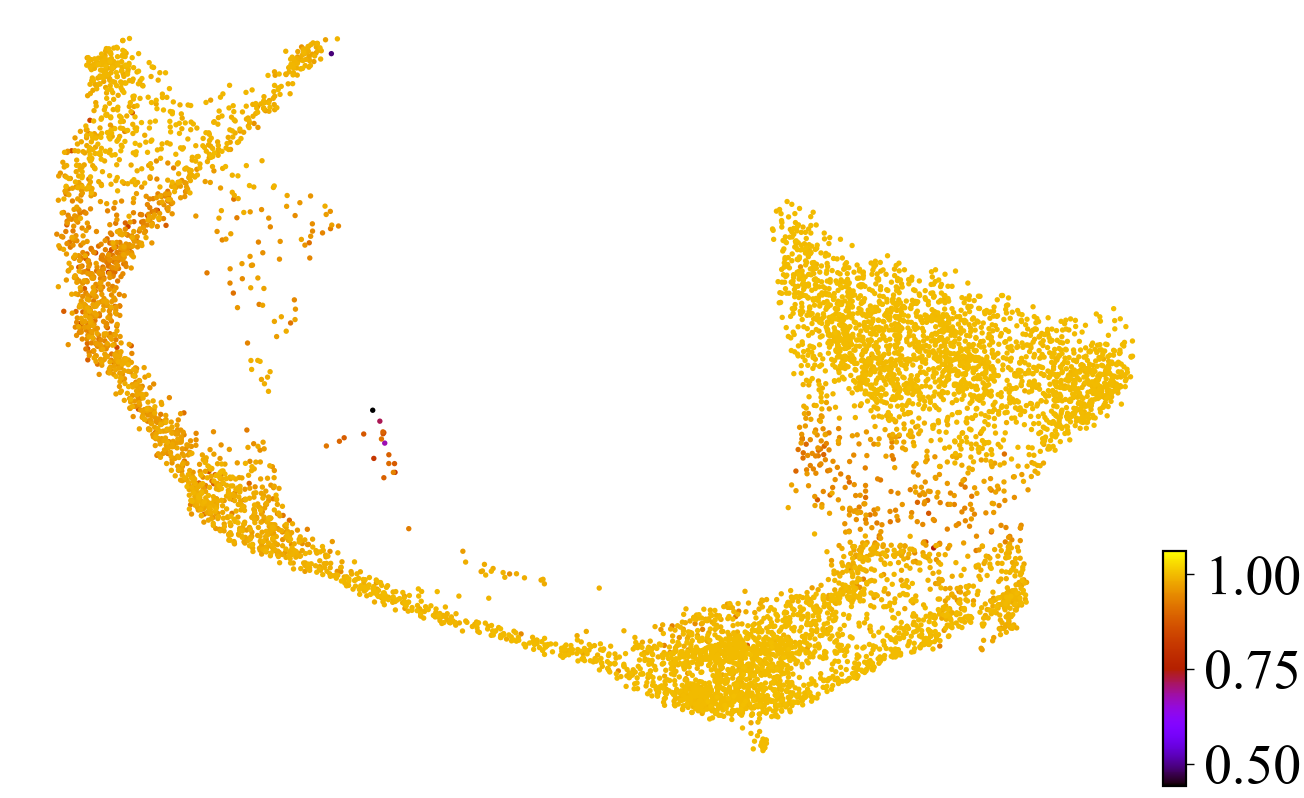

In [130]:
scv.pl.scatter(adata, color=['velocity_confidence'],
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               color_map="none",
               title="",
               #save="velconf_pancreas1415_trajectorynet.png"
              )

In [132]:
adata.write("../notebooks/adata_results/pancreas1415_trajectorynet.h5ad")